# Optimization Method: SOPDT to Data

A second-order linear system with time delay is an empirical description of potentially oscillating dynamic processes. The equation

$$\tau_s^2 \frac{d^2y}{dt^2} + 2 \zeta \tau_s \frac{dy}{dt} + y = K_p \, u\left(t-\theta_p \right)$$

has output $y(t)$ and input $u(t)$ and four unknown parameters. The four parameters are the gain $K_{p}$, damping factor $\zeta$, second order time constant $\tau_{s}$, and dead time $\theta_{p}$.

An alternative to the graphical fitting approach is to use optimization to best match an SOPDT model to data. A common objective is to minimize a sum of squared error that penalizes deviation of the SOPDT model from the data. The optimization algorithm changes the parameters $(K_{p}, \tau_{p}, \zeta, \theta_{p})$ to best match the data at specified time points.

### Generate Simulated Data from Model

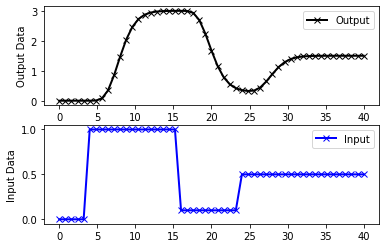

In [1]:
# Generate process data as data.txt
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# define process model (to generate process data)
def process(y,t,n,u,Kp,taup):
    # arguments
    #  y[n] = outputs
    #  t    = time
    #  n    = order of the system  
    #  u    = input value
    #  Kp   = process gain
    #  taup = process time constant

    # equations for higher order system
    dydt = np.zeros(n)
    # calculate derivative
    dydt[0] = (-y[0] + Kp * u)/(taup/n)
    for i in range(1,n):
       dydt[i] = (-y[i] + y[i-1])/(taup/n)
    return dydt

# specify number of steps
ns = 50
# define time points
t = np.linspace(0,40,ns+1)
delta_t = t[1]-t[0]
# define input vector
u = np.zeros(ns+1)
u[5:20] = 1.0
u[20:30] = 0.1
u[30:] = 0.5

# use this function or replace yp with real process data
def sim_process_data():
    # higher order process
    n=10       # order
    Kp=3.0    # gain
    taup=5.0   # time constant
    # storage for predictions or data
    yp = np.zeros(ns+1)  # process
    for i in range(1,ns+1):
        if i==1:
            yp0 = np.zeros(n)
        ts = [delta_t*(i-1),delta_t*i]
        y = odeint(process,yp0,ts,args=(n,u[i],Kp,taup))
        yp0 = y[-1]
        yp[i] = y[1][n-1]
    return yp
yp = sim_process_data()

# Construct results and save data file
# Column 1 = time
# Column 2 = input
# Column 3 = output
data = np.vstack((t,u,yp)) # vertical stack
data = data.T              # transpose data
np.savetxt('data/data.txt',data,delimiter=',',comments='',header='time,u,y')

# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,yp,'kx-',linewidth=2,label='Output')
plt.ylabel('Output Data')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.legend(['Input'],loc='best')
plt.ylabel('Input Data')
plt.show()

### SOPDT Fit to Data

Initial SSE Objective: 44.242421067706736
Final SSE Objective: 0.029303709551862792
Kp: 2.987521509493719
taup: 1.5126216616504953
zeta: 0.8367065414392438
thetap: 2.04782033880674


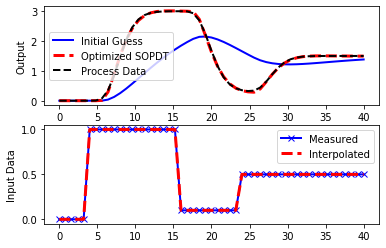

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import warnings

# Import CSV data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
url = 'http://apmonitor.com/pdc/uploads/Main/data_fopdt.txt'
data = pd.read_csv(url)
t = data['time'].values - data['time'].values[0]
u = data['u'].values
yp = data['y'].values
u0 = u[0]
y0 = yp[0]
xp0 = yp[0]

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

def sopdt(x,t,uf,Kp,taus,zeta,thetap):
    # Kp = process gain
    # taus = second order time constant
    # zeta = damping factor
    # thetap = model time delay
    # ts^2 dy2/dt2 + 2 zeta taus dydt + y = Kp u(t-thetap)
    # time-shift u
    try:
        if (t-thetap) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetap)
    except:
        # catch any error
        um = u0
    # two states (y and y')
    y = x[0] - y0
    dydt = x[1]
    dy2dt2 = (-2.0*zeta*taus*dydt - y + Kp*(um-u0))/taus**2
    return [dydt,dy2dt2]

# simulate model with x=[Km,taum,thetam]
def sim_model(x):
    # input arguments
    Kp = x[0]
    taus = x[1]
    zeta = x[2]
    thetap = x[3]
    # storage for model values
    xm = np.zeros((ns,2))  # model
    # initial condition
    xm[0] = xp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        inputs = (uf,Kp,taus,zeta,thetap)
        # turn off warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # integrate SOPDT model
            x = odeint(sopdt,xm[i],ts,args=inputs)
        xm[i+1] = x[-1]
    y = xm[:,0]
    return y

# define objective
def objective(x):

    # simulate model

    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2    

    # return result
    return obj

# initial guesses
p0 = np.zeros(4)
p0[0] = 3 # Kp
p0[1] = 5.0 # taup
p0[2] = 1.0 # zeta
p0[3] = 2.0 # thetap

# show initial objective
print('Initial SSE Objective: ' + str(objective(p0)))

# optimize Kp, taus, zeta, thetap
solution = minimize(objective,p0)

# with bounds on variables
#no_bnd = (-1.0e10, 1.0e10)
#low_bnd = (0.01, 1.0e10)
#bnds = (no_bnd, low_bnd, low_bnd, low_bnd)
#solution = minimize(objective,p0,method='SLSQP',bounds=bnds)
p = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(p)))

print('Kp: ' + str(p[0]))
print('taup: ' + str(p[1]))
print('zeta: ' + str(p[2]))
print('thetap: ' + str(p[3]))

# calculate model with updated parameters
ym1 = sim_model(p0)
ym2 = sim_model(p)

# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized SOPDT')
plt.plot(t,yp,'k--',linewidth=2,label='Process Data')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.savefig('pictures/results.png')
plt.show()